# Argumentation framework

In [4]:
from utils.test.index import get_testers
from utils.test.tester import test
from utils.test.tester import displayGraph
import os

# Complete, stable and preferred
test(
    testers=get_testers(types=[ "gr"])[:2],
    solvers=["manysat", "glucose"],
    semantics=["CO", "ST"],
    tasks=["SE", "EE"],
    timeout=1,  # seconds
)

 Tester 2/2 gr EE-ST dpll Timeouts: 4                        

True

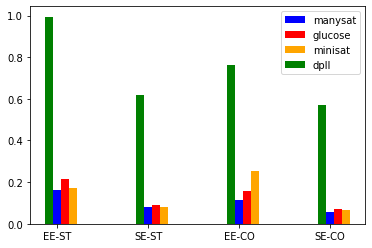

In [5]:
import pandas as pd
from utils.test.tester import displayGraph

displayGraph("TEST1234.csv")


In [ ]:
# from utils.gen.stable import gen as gen_stable
from utils.gen.grounded import gen as gen_grounded

# g_stable = gen_stable(10000, 100, 1000, 100, 1000, 100, 1000, .6)
# g_stable.save("stable.txt")

g_grounded = gen_grounded(500, .3)
g_grounded.save("grounded")

In [ ]:
# bench(
#     solvers=["manysat", "minisat"],
#     semantics="CO",
#     tasks="SE",
#     graphs=[(a, gen_grounded(a, .3)) for a in range(0, 10)],
#     abs="max arg",
#     ord="time",
# )

# SUPPOSED TO:
# Générer une image d'un graphe pour manysat et un autre pour minisat
# (les deux courbes sur le même graphique)
# avec la sémanntique CO et la tâche SE
# en abscisses: a
# en ordonnées: le temps d'exécution pour résoudre gen_grounded(a, .3)
# du coup il y aurait 10 points par courbe

# AUTRE EXEMPLE
# bench(
#     solvers=["manysat", "minisat"],
#     semantics="CO",
#     tasks="SE",
#     graphs=[(count_arguments(file), file) for file in graph_files],
#     abs="max arg",
#     ord="time",
# )

In [ ]:
from utils.solve import solve
from utils.benchmark import benchmark
from utils.reprandom import rr
from pathlib import Path

rep = 10

solvers = ["dpll", "minisat", "manysat", "glucose"]

times = {}

for solver in solvers:
    times[solver] = 0

problems = []
for _ in range(rep):
    for solver in solvers:
        problems.append(solver)

sorted(problems, key = lambda _: rr.random())

for problem in problems:
    times[problem] += benchmark(
        solve,
        Path.cwd().joinpath("graph", "grounded.tgf"),
        "SE-ST",
        solvers=[problem],
    )

for solver in solvers:
    times[solver] /= rep

times